# Vertex AI Gemini + LangChain + Astra DB - RAG Intro

### Intro

In this notebook, we're going to show you how to use  LangChain, Vertex AI, Gemini, RAG and Astra DB to perform multi-modal Retrieval Augmented Generation (RAG).

Before running through this notebook:
1. Make sure you have created an Astra DB account.  After creating a vector database, get your endpoint and token from here: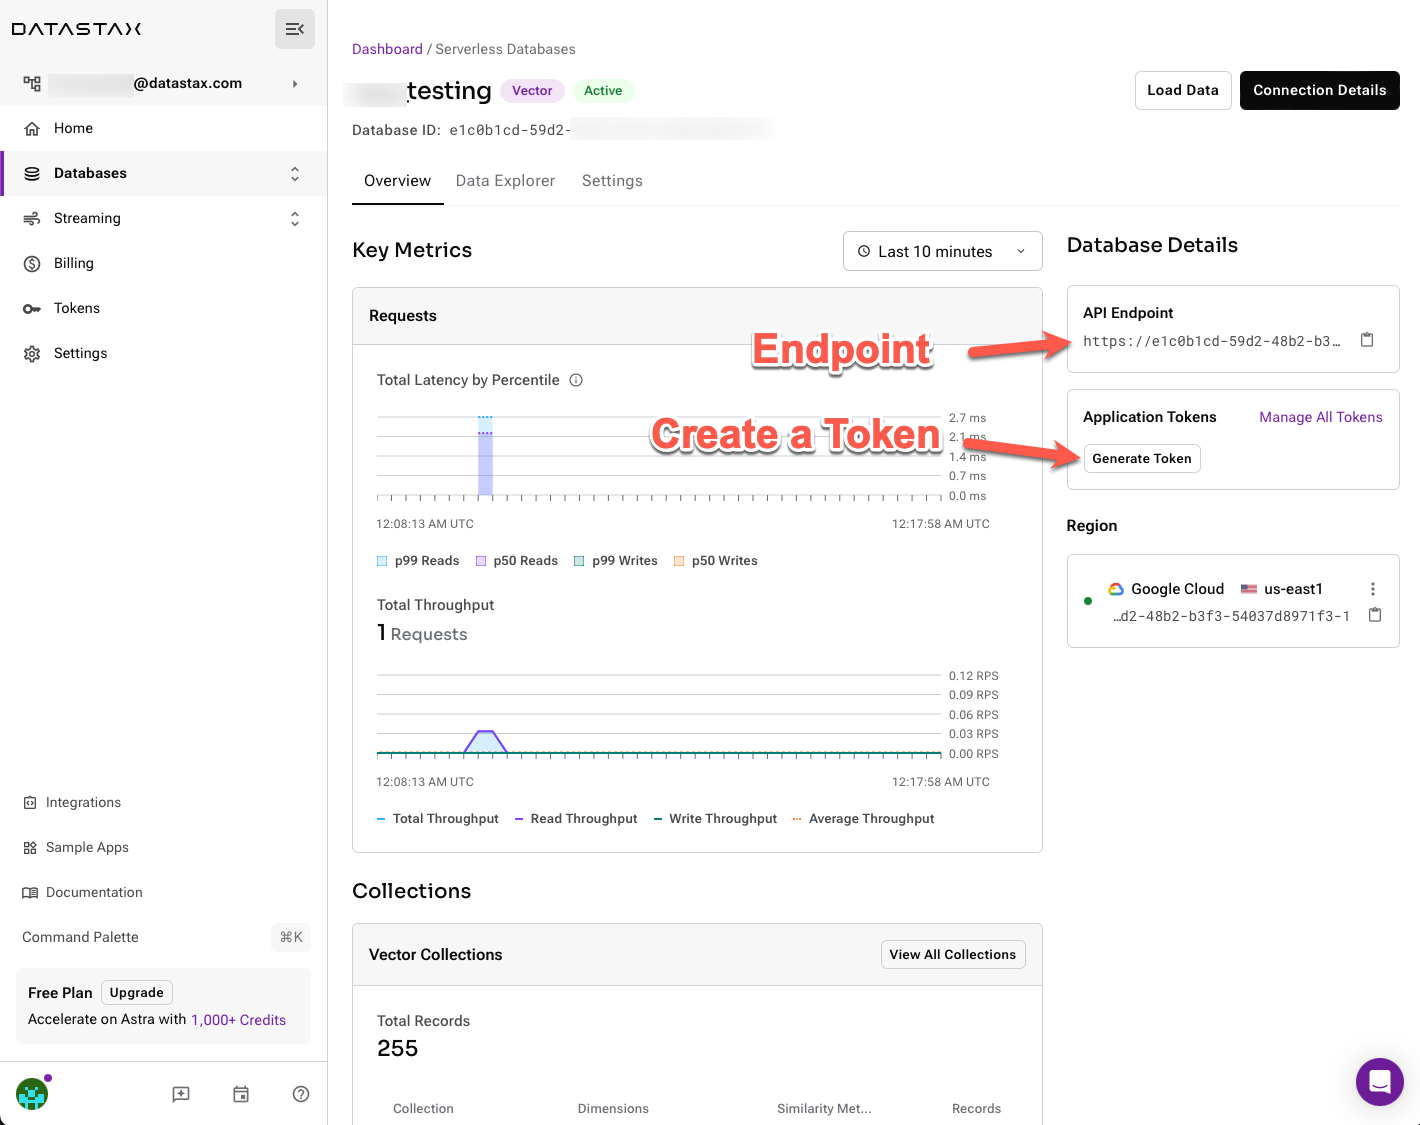
2. Make sure you have created a Vertex AI account.
Get your Project ID from here: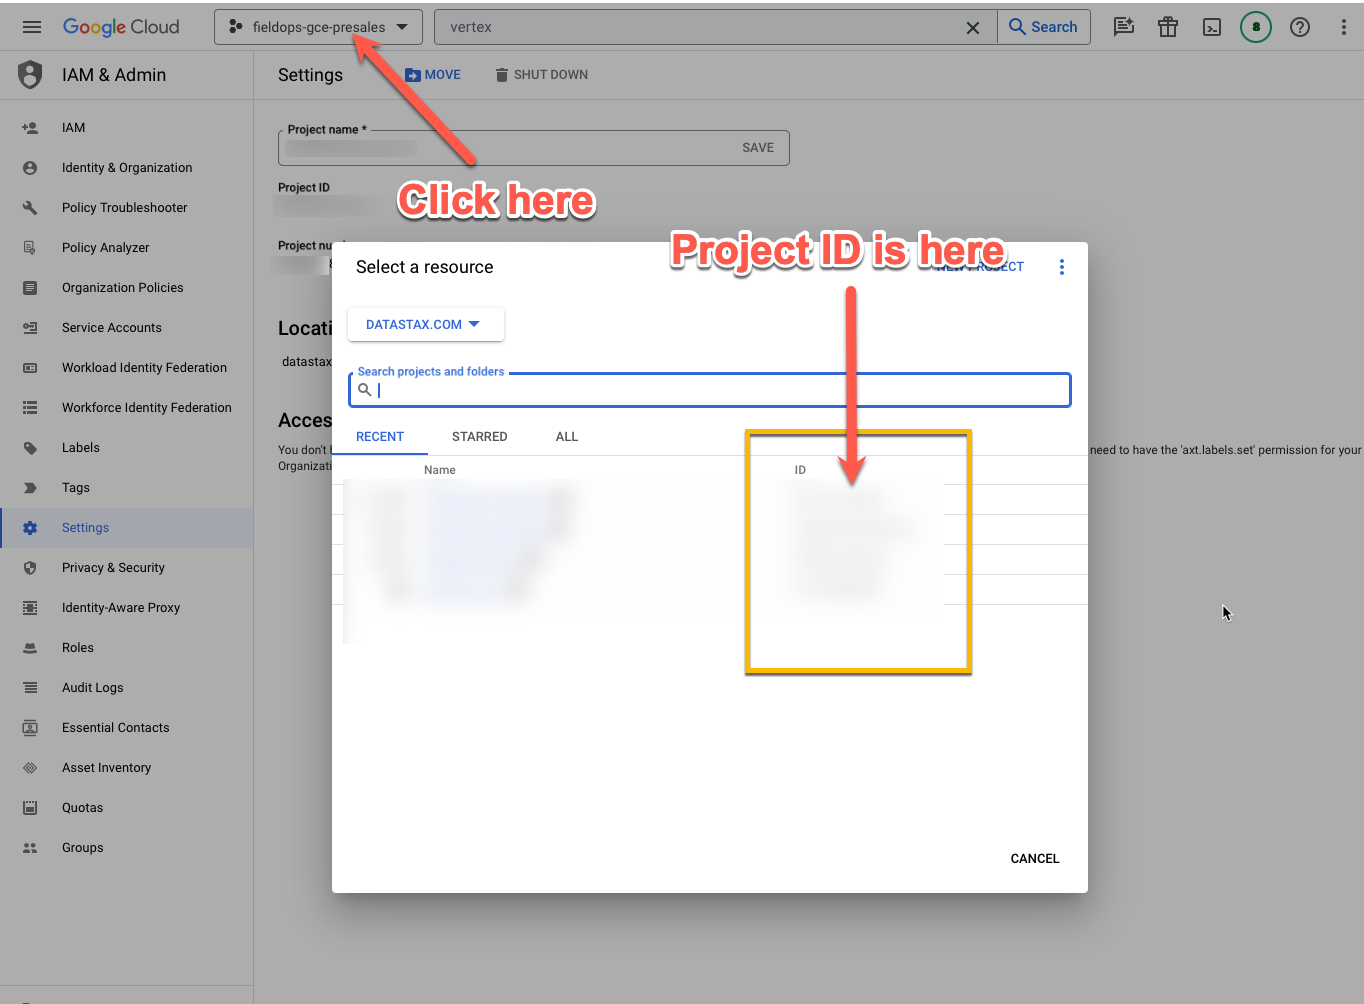

###Install Python dependencies

In [ ]:
!pip install google-cloud-aiplatform ragstack-ai --upgrade

###Load Astra DB and Vertex AI credentials



In [ ]:
import getpass, os, requests

if "GCP_PROJECT_ID" not in os.environ:
  os.environ["GCP_PROJECT_ID"] = getpass.getpass("Provide your GCP Project ID")

if "ASTRA_DB_ENDPOINT" not in os.environ:
  os.environ["ASTRA_DB_ENDPOINT"] = getpass.getpass("Provide your Astra DB Endpoint")

if "ASTRA_DB_TOKEN" not in os.environ:
  os.environ["ASTRA_DB_TOKEN"] = getpass.getpass("Provide your Astra DB Token")

###Configure Google Vertex AI Credentials:
You should see a popup that you must authorize to use your Google Cloud account.  If a window doesn't pop up, it may be blocked by a popup blocker.

In [ ]:
from google.colab import auth
from google.cloud import aiplatform

!gcloud config set project {os.getenv("GCP_PROJECT_ID")}

auth.authenticate_user()


### Use Gemini Pro vision to identify an item
I broke a piece to my coffee machine but I really don't know what it is, what it's called, or where to get a replacement.  

Gemini pro vision can help!  


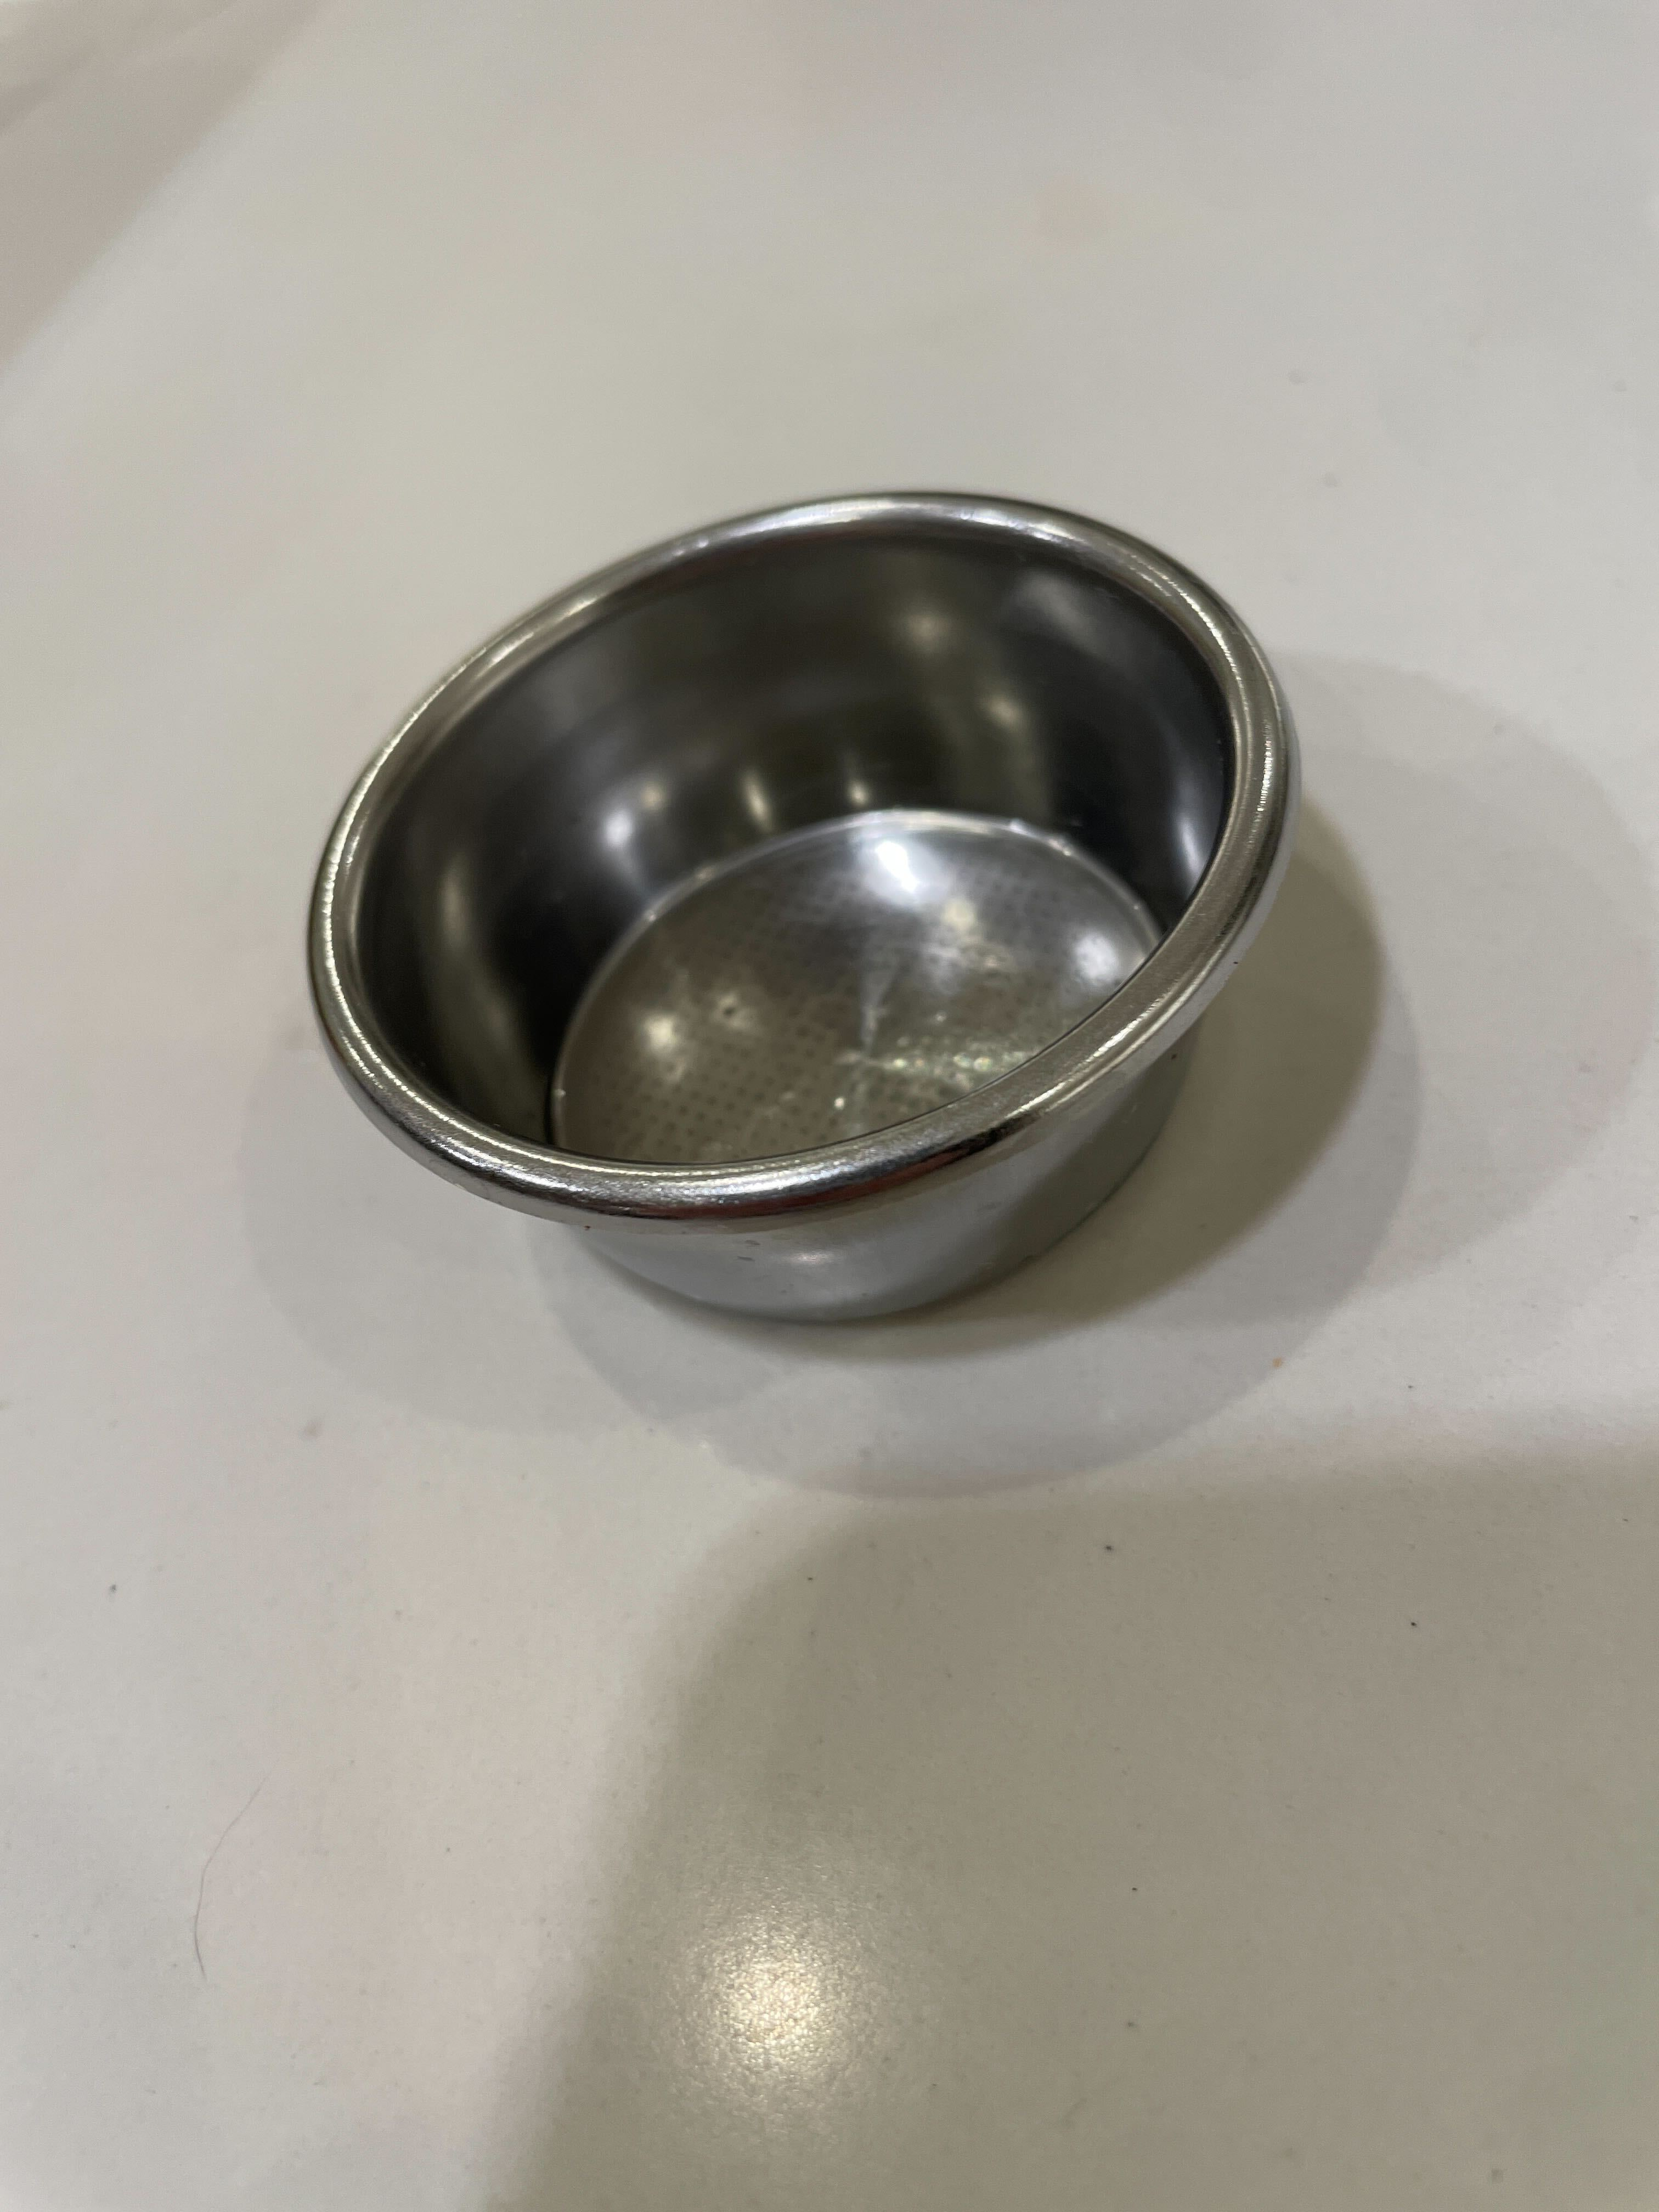

First, let's download this picture I took of the part.  We'll save it in the Google Colab filesystem.

In [ ]:
source_img_data = requests.get('https://drive.google.com/uc?export=view&id=15ddcn-AIxpvRdWcFGvIr77XLWdo4Maof').content
with open('coffee_maker_part.png', 'wb') as handler:
  handler.write(source_img_data)

Now we're going to ask Gemini Pro Vision to identify the part in the picture.

In [ ]:
from langchain.chat_models import ChatVertexAI
from langchain.schema.messages import HumanMessage
from PIL import Image, ImageFile
import os, sys

llm = ChatVertexAI(project=os.getenv("GCP_PROJECT_ID"), model_name="gemini-pro-vision", region="uswest-1")

image_message = {
    "type": "image_url",
    "image_url": {"url": "coffee_maker_part.png"},
}
text_message = {
    "type": "text",
    "text": "What is this image? Share a link to purchase a replacement",
}
message = HumanMessage(content=[text_message, image_message])

output = llm([message])
print(output.content)

Amazingly, Gemini was able to correctly identify the part.  However, it gave us an out-of-date link to purchase a replacement.  Similarly, if the part was newer than the LLM, it would not have been able to identify it.  Luckily, with Retreival Augmented Generation, we can address both of these problems!

### Load an eCommerce coffee shop product catalog

We need to be able to search our own database for pictures that look similar to the one provided by the user.  To do that, let's create a database and download the referenced images.  


In [ ]:
import pandas as pd

d = {'name': ["Saucer", "Saucer Ceramic", "Milk Jug Assembly", "Handle Steam Wand Kit (New Version From 0735 PDC)", "Spout Juice Small (From 0637 to 1041 PDC)", "Cleaning Steam Wand", "Jug Frothing", "Spoon Tamping 50mm", "Collar Grouphead 50mm", "Filter 2 Cup Dual Wall 50mm", "Filter 1 Cup 50mm", "Water Tank Assembly", "Portafilter Assembly 50mm", "Milk Jug Assembly", "Filter 2 Cup 50mm" ],
     'url': ["https://www.breville.com/us/en/parts-accessories/parts/sp0014946.html?sku=SP0014946", "https://www.breville.com/us/en/parts-accessories/parts/sp0014914.html?sku=SP0014914", "https://www.breville.com/us/en/parts-accessories/parts/sp0011391.html?sku=SP0011391", "https://www.breville.com/us/en/parts-accessories/parts/sp0010719.html?sku=SP0010719", "https://www.breville.com/us/en/parts-accessories/parts/sp0010718.html?sku=SP0010718", "https://www.breville.com/us/en/parts-accessories/parts/sp0003247.html?sku=SP0003247", "https://www.breville.com/us/en/parts-accessories/parts/sp0003246.html?sku=SP0003246", "https://www.breville.com/us/en/parts-accessories/parts/sp0003243.html?sku=SP0003243", "https://www.breville.com/us/en/parts-accessories/parts/sp0003232.html?sku=SP0003232", "https://www.breville.com/us/en/parts-accessories/parts/sp0003231.html?sku=SP0003231", "https://www.breville.com/us/en/parts-accessories/parts/sp0003230.html?sku=SP0003230", "https://www.breville.com/us/en/parts-accessories/parts/sp0003225.html?sku=SP0003225", "https://www.breville.com/us/en/parts-accessories/parts/sp0003216.html?sku=SP0003216", "https://www.breville.com/us/en/parts-accessories/parts/sp0001875.html?sku=SP0001875", "https://www.breville.com/us/en/parts-accessories/parts/sp0000166.html?sku=SP0000166"],
     'price': ["10.95", "4.99", "14.95", "8.95", "10.95", "6.95", "24.95", "8.95", "6.95", "12.95", "12.95", "14.95", "10.95", "16.95", "11.95"],
     'image': ["https://www.breville.com/content/dam/breville/us/catalog/products/images/sp0/sp0014946/tile.jpg", "https://www.breville.com/content/dam/breville/us/catalog/products/images/sp0/sp0014914/tile.jpg", "https://www.breville.com/content/dam/breville/us/catalog/products/images/sp0/sp0011391/tile.jpg", "https://www.breville.com/content/dam/breville/ca/catalog/products/images/sp0/sp0010719/tile.jpg", "https://www.breville.com/content/dam/breville/ca/catalog/products/images/sp0/sp0010718/tile.jpg", "https://www.breville.com/content/dam/breville/ca/catalog/products/images/sp0/sp0003247/tile.jpg", "https://assets.breville.com/cdn-cgi/image/width=400,format=auto/Spare+Parts+/Espresso+Machines/BES250/SP0003246/SP0003246_IMAGE1_400X400.jpg", "https://assets.breville.com/cdn-cgi/image/width=400,format=auto/Spare+Parts+/Espresso+Machines/ESP8/SP0003243/SP0003243_IMAGE1_400X400.jpg", "https://assets.breville.com/cdn-cgi/image/width=400,format=auto/Spare+Parts+/Espresso+Machines/ESP8/SP0003232/SP0003232_IMAGE1_400x400.jpg", "https://www.breville.com/content/dam/breville/au/catalog/products/images/sp0/sp0003231/tile.jpg", "https://www.breville.com/content/dam/breville/au/catalog/products/images/sp0/sp0003230/tile.jpg", "https://www.breville.com/content/dam/breville/ca/catalog/products/images/sp0/sp0003225/tile.jpg", "https://www.breville.com/content/dam/breville/ca/catalog/products/images/sp0/sp0003216/tile.jpg", "https://www.breville.com/content/dam/breville/au/catalog/products/images/sp0/sp0001875/tile.jpg", "https://www.breville.com/content/dam/breville/us/catalog/products/images/sp0/sp0000166/tile.jpg"]}
df = pd.DataFrame(data=d)
df


Next, we'll create vector embeddings of each of the product images using Google's Multi-Modal Embedding Model and save the data in AstraDB.  

In [ ]:
import vertexai, json, requests
from vertexai.preview.vision_models import MultiModalEmbeddingModel, Image
from astrapy.db import AstraDB, AstraDBCollection
from google.colab import files

model = MultiModalEmbeddingModel.from_pretrained("multimodalembedding@001")

# Initialize our vector db
astra_db = AstraDB(token=os.getenv("ASTRA_DB_TOKEN"), api_endpoint=os.getenv("ASTRA_DB_ENDPOINT"))
collection = astra_db.create_collection(collection_name="coffee_shop_ecommerce", dimension=1408)

for i in range(len(df)):
  name = df.loc[i, "name"]
  image = df.loc[i, "image"]
  price = df.loc[i, "price"]
  url = df.loc[i, "url"]

  # Download this product's image and save it to the Colab filesystem.
  # In a production system this binary data would be stored in Google Cloud Storage
  img_data = requests.get(image).content
  with open(f'{name}.png', 'wb') as handler:
    handler.write(img_data)

  # load the image from filesystem and compute the embedding value
  img = Image.load_from_file(f'{name}.png')
  embeddings = model.get_embeddings(image=img, contextual_text=name)

  try:
    # add to the AstraDB Vector Database
    collection.insert_one({
        "_id": i,
        "name": name,
        "image": image,
        "url": url,
        "price": price,
        "$vector": embeddings.image_embedding,
      })
  except Exception as error:
    # if you've already added this record, skip the error message
    error_info = json.loads(str(error))
    if error_info[0]['errorCode'] == "DOCUMENT_ALREADY_EXISTS":
      print("Document already exists in the database.  Skipping.")

### Multimodal RAG
Now let's ask the LLM the same question but this time we'll perform a vector search against AstraDB using the same image to supply the LLM with relevant products in the prompt.

In [ ]:
import json

# Embed the similar item
img = Image.load_from_file('coffee_maker_part.png')
embeddings = model.get_embeddings(image=img, contextual_text="A espresso machine part")

# Perform the vector search against AstraDB Vector
documents = collection.vector_find(
    embeddings.image_embedding,
    limit=3,
)

related_products_csv = "name, image, price, url\n"
for doc in documents:
  related_products_csv += f"{doc['name']}, {doc['image']}, {doc['price']}, {doc['url']},\n"

image_message = {
    "type": "image_url",
    "image_url": {"url": "coffee_maker_part.png"},
}
text_message = {
    "type": "text",
    "text": f"What is this image? Share the URL and price to purchase a replacement. Here are related products {related_products_csv}",
}
message = HumanMessage(content=[text_message, image_message])
output = llm([message])
print(output.content)